<a href="https://www.kaggle.com/code/kwangsoo2/dlappsclass-pytorch?scriptVersionId=98400017" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# DL Apps Class Project(Kaggle track)
### Competition: Contradictory, My Dear Watson

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import random
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import matplotlib.pyplot as plt
import os
import tqdm
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from argparse import Namespace

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
# set random seed for reproduce
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(42)

## Get Dataset

In [3]:
full_dataset = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test_dataset = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

# split train dataset into train dataset and validation dataset
train_dataset = full_dataset.sample(frac=0.8,random_state=200)
val_dataset = full_dataset.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [4]:
# check the dataset
print(train_dataset.head(3))
print(test_dataset.head(3))

           id                                            premise  \
0  30b841cd73                   are you originally from uh Texas   
1  902b8bdecc  سانتا فی میں، جہاں ہسپانوی ورثہ اور آبادی کافی...   
2  966814bd2b  The anthropologist Napoleon Chagnon has shown ...   

                                          hypothesis lang_abv language  label  
0                      You're originally from Texas?       en  English      0  
1     سانتا فے میں زیادہ تر لوگوں کے نام ہسپانوی ہیں       ur     Urdu      1  
2  There is a direct correlation between Yanomamo...       en  English      0  
           id                                            premise  \
0  c6d58c3f69  بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...   
1  cefcc82292                             هذا هو ما تم نصحنا به.   
2  e98005252c  et cela est en grande partie dû au fait que le...   

                                          hypothesis lang_abv language  
0  کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...       ur

In [5]:
# training dataset info
print('full data num:', len(full_dataset.premise.values))
print('train data num:', len(train_dataset.premise.values))
print('val data num:', len(val_dataset.premise.values))

full data num: 12120
train data num: 9696
val data num: 2424


train_dataset


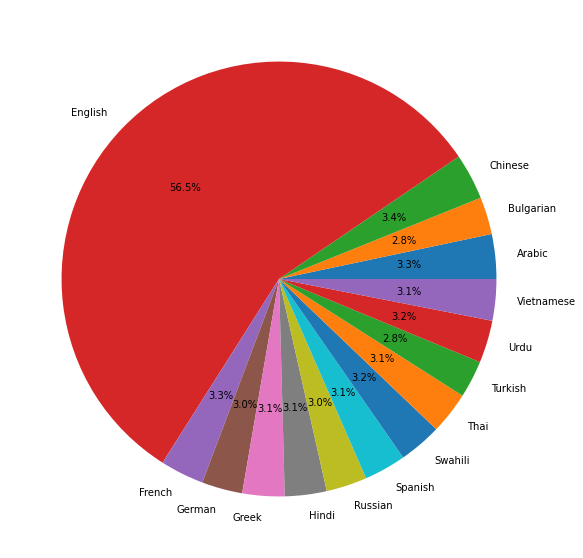

val_dataset


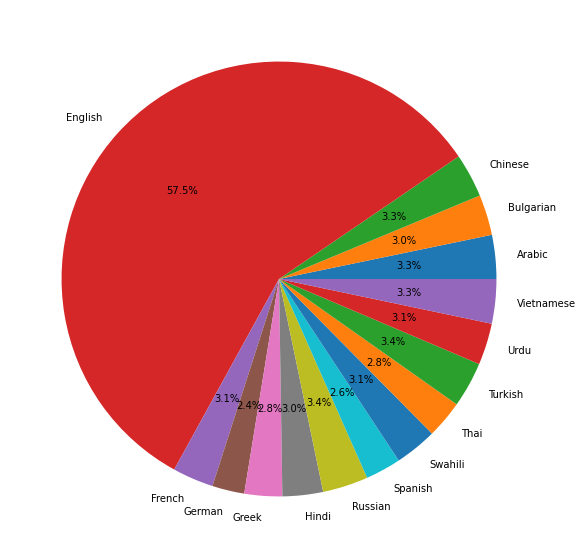

test_dataset


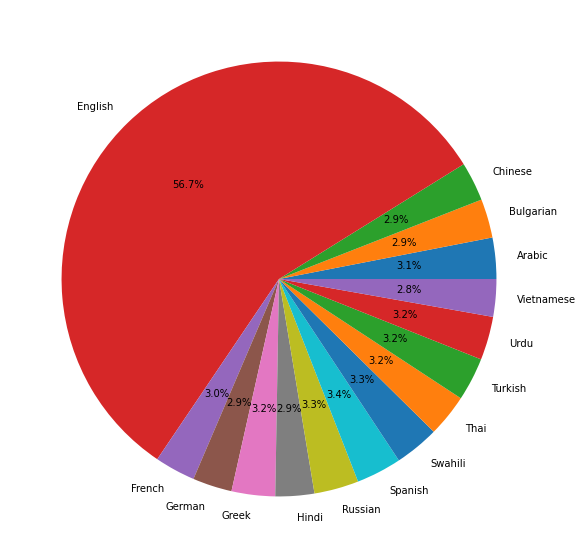

In [6]:
# see language distribution of the datasets
labels, frequencies = np.unique(train_dataset.language.values, return_counts = True)

print('train_dataset')
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

labels, frequencies = np.unique(val_dataset.language.values, return_counts = True)

print('val_dataset')
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

labels, frequencies = np.unique(test_dataset.language.values, return_counts = True)

print('test_dataset')
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

train_dataset


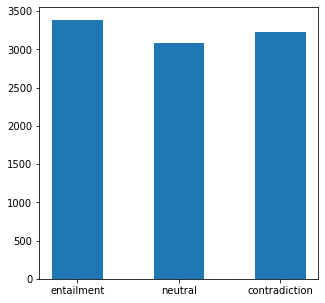

val_dataset


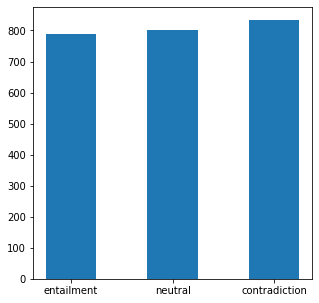

In [7]:
# see label distribution of the datasets 
print('train_dataset')
labels, frequencies = np.unique(train_dataset.label.values, return_counts = True)

plt.figure(figsize = (5,5))

label_name = ['entailment', 'neutral', 'contradiction'] 

plt.bar(labels, frequencies, width=0.5)
plt.xticks(labels, label_name)

plt.show()

print('val_dataset')
labels, frequencies = np.unique(val_dataset.label.values, return_counts = True)

plt.figure(figsize = (5,5))

label_name = ['entailment', 'neutral', 'contradiction'] 

plt.bar(labels, frequencies, width=0.5)
plt.xticks(labels, label_name)

plt.show()

## Data preprocessing

In [8]:
class DataBert(Dataset):

    def __init__(self, train_df, val_df, test_df, tokenizer):
        self.label_dict = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.tokenizer = tokenizer
        self.train_data = None
        self.val_data = None
        self.test_data = None
        self.init_data()

    def init_data(self):
        self.train_data = self.load_data(self.train_df)
        self.val_data = self.load_data(self.val_df)
        self.test_data = self.load_data(self.test_df, train=False)

    def load_data(self, df, train=True):
        MAX_LEN = 512
        token_ids = []
        mask_ids = []
        seg_ids = []
        y = []

        if train:
            hypothesis_list = df['hypothesis'].to_list()
            premise_list = df['premise'].to_list()
            label_list = df['label'].to_list()

            for (hypothesis, premise, label) in zip(hypothesis_list, premise_list, label_list):
                hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
                premise_id = self.tokenizer.encode(premise, add_special_tokens = False)
                pair_token_ids = [self.tokenizer.cls_token_id] + hypothesis_id + [self.tokenizer.sep_token_id] + premise_id + [self.tokenizer.sep_token_id]
                hypothesis_len = len(hypothesis_id)
                premise_len = len(premise_id)

                segment_ids = torch.tensor([0] * (hypothesis_len + 1) + [1] * (premise_len + 2))  # sentence 0 and sentence 1
                attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

                token_ids.append(torch.tensor(pair_token_ids))
                seg_ids.append(segment_ids)
                mask_ids.append(attention_mask_ids)
                y.append(label)

            token_ids = pad_sequence(token_ids, batch_first=True)
            mask_ids = pad_sequence(mask_ids, batch_first=True)
            seg_ids = pad_sequence(seg_ids, batch_first=True)
            y = torch.tensor(y)
            dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
        else:
            hypothesis_list = df['hypothesis'].to_list()
            premise_list = df['premise'].to_list()

            for (hypothesis, premise) in zip(hypothesis_list, premise_list):
                hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
                premise_id = self.tokenizer.encode(premise, add_special_tokens = False)
                pair_token_ids = [self.tokenizer.cls_token_id] + hypothesis_id + [self.tokenizer.sep_token_id] + premise_id + [self.tokenizer.sep_token_id]
                hypothesis_len = len(hypothesis_id)
                premise_len = len(premise_id)

                segment_ids = torch.tensor([0] * (hypothesis_len + 1) + [1] * (premise_len + 2))  # sentence 0 and sentence 1
                attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

                token_ids.append(torch.tensor(pair_token_ids))
                seg_ids.append(segment_ids)
                mask_ids.append(attention_mask_ids)

            token_ids = pad_sequence(token_ids, batch_first=True)
            mask_ids = pad_sequence(mask_ids, batch_first=True)
            seg_ids = pad_sequence(seg_ids, batch_first=True)
            dataset = TensorDataset(token_ids, mask_ids, seg_ids)

        return dataset

    def get_data_loaders(self, batch_size=32, shuffle=True):
        train_loader = DataLoader(
          self.train_data,
          shuffle=shuffle,
          batch_size=batch_size
        )
        val_loader = DataLoader(
          self.val_data,
          shuffle=shuffle,
          batch_size=batch_size
        )
        test_loader = DataLoader(
          self.test_data,
          batch_size=1
        )
        return train_loader, val_loader, test_loader

In [9]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences

nli_dataset = DataBert(train_dataset, val_dataset, test_dataset, bert_tokenizer)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Get BERT model

In [10]:
device = "cuda"
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Training

In [11]:
# helper function
def get_acc(pred, gt):
    gt = gt.to('cpu')
    acc = (torch.tensor(pred) == gt).sum().float() / float(gt.size(0))
    return acc

In [12]:
EPOCHS = 7

def train(model, train_loader, val_loader, optimizer, scheduler=None):  
#     total_step = len(train_loader)
    device = "cuda"
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []
    prev_loss = 100
    prev_acc = 0
    for epoch in range(EPOCHS):
        start = time.time()
        model.train()
        total_train_loss = 0
        total_train_acc  = 0
        for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
            optimizer.zero_grad()
            pair_token_ids = pair_token_ids.to(device)
            mask_ids = mask_ids.to(device)
            seg_ids = seg_ids.to(device)
            labels = y.to(device)

            outputs = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids,
                            labels=labels)
            prediction = [torch.argmax(logit).cpu().detach().item() for logit in outputs.logits]
            loss = outputs.loss
            total_train_loss += loss.item()
            total_train_acc += get_acc(prediction, labels).item()            

            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            

        train_acc  = total_train_acc/len(train_loader)
        train_loss = total_train_loss/len(train_loader)

        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        
        model.eval()
        total_val_acc  = 0
        total_val_loss = 0
        with torch.no_grad():
            for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
                optimizer.zero_grad()
                pair_token_ids = pair_token_ids.to(device)
                mask_ids = mask_ids.to(device)
                seg_ids = seg_ids.to(device)
                labels = y.to(device)

                outputs = model(pair_token_ids, 
                                token_type_ids=seg_ids, 
                                attention_mask=mask_ids,
                                labels=labels)

                prediction = [torch.argmax(logit).cpu().detach().item() for logit in outputs.logits]

                loss = outputs.loss
                total_val_loss += loss.item()
                total_val_acc += get_acc(prediction, labels).item()   

        val_acc  = total_val_acc/len(val_loader)
        val_loss = total_val_loss/len(val_loader)

        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)
        
        end = time.time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)

        print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
        # best loss?
        if val_loss > prev_loss:
            return epoch, train_acc_history, train_loss_history, val_acc_history, val_loss_history
#         # best acc?
#         if val_acc < prev_acc:
#             return epoch, train_acc_history, train_loss_history, val_acc_history, val_loss_history
        prev_loss = val_loss
        prev_acc = val_acc
    return train_acc_history, train_loss_history, val_acc_history, val_loss_history

In [13]:
train_loader, val_loader, test_loader = nli_dataset.get_data_loaders(batch_size=8)

# optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# lr decay
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)

last_epoch, t_a_his, t_l_his, v_a_his, v_l_his = train(model, train_loader, val_loader, optimizer, scheduler)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch 1: train_loss: 1.1049 train_acc: 0.3395 | val_loss: 1.1016 val_acc: 0.3441
00:06:07.81
Epoch 2: train_loss: 1.0820 train_acc: 0.3814 | val_loss: 1.0298 val_acc: 0.4460
00:06:06.52
Epoch 3: train_loss: 0.9494 train_acc: 0.5248 | val_loss: 0.9076 val_acc: 0.5479
00:06:06.72
Epoch 4: train_loss: 0.7669 train_acc: 0.6367 | val_loss: 0.9426 val_acc: 0.5850
00:06:06.81


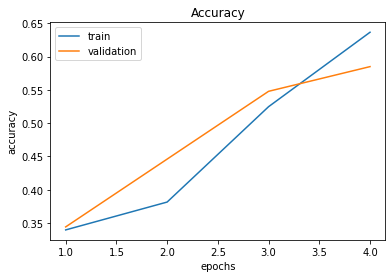

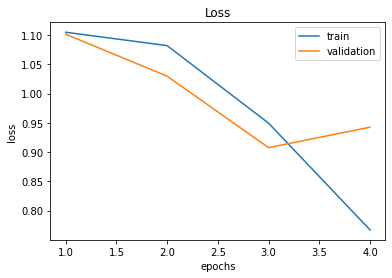

In [14]:
# show the history
# accuracy
plt.plot(range(1, last_epoch + 2), t_a_his)
plt.plot(range(1, last_epoch + 2), v_a_his)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend(['train', 'validation'])
plt.show()

# loss
plt.plot(range(1, last_epoch + 2), t_l_his)
plt.plot(range(1, last_epoch + 2), v_l_his)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(['train', 'validation'])
plt.show()

## Generating prediction

In [15]:
def eval(model, test_loader, scheduler=None):
    model.eval()
    start = time.time()
    pred = []
    with torch.no_grad():
        for batch_idx, (pair_token_ids, mask_ids, seg_ids) in enumerate(test_loader):
            optimizer.zero_grad()
            pair_token_ids = pair_token_ids.to(device)
            mask_ids = mask_ids.to(device)
            seg_ids = seg_ids.to(device)

            outputs = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids)
            
            prediction = [torch.argmax(logit).cpu().detach().item() for logit in outputs.logits]
            
            for i in range(len(prediction)):
                pred.append(prediction[i])

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    return np.array(pred, dtype=np.int64)

In [16]:
preds = eval(model, test_loader)

00:01:20.97


In [17]:
submission = test_dataset.id.copy().to_frame()
submission['prediction'] = preds
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,2
2,e98005252c,0
3,58518c10ba,0
4,c32b0d16df,0


In [18]:
submission.to_csv("submission.csv", index = False)